## Implement a Simulation Function for the NS Equations:

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.sparse import diags_array,identity, kron
from scipy.sparse.linalg import splu
from scipy.interpolate import RegularGridInterpolator
import sys

# Sources:
# Stable Fluids, Stam 1999   https://pages.cs.wisc.edu/~chaol/data/cs777/stam-stable_fluids.pdf
# Fast Fluid Dynamics Simulation on the GPU, Harris 2004           https://cg.informatik.uni-freiburg.de/intern/seminar/gridFluids_GPU_Gems.pdf
def navier_stokes(x_range, n, t_max, iters, samples, init_U_func=lambda x,y: (0, 0), F=lambda X,Y,t: (X,Y,t), objects=lambda X,Y,t:np.zeros_like(X), viscosity=-20):
    dx = (x_range[1] - x_range[0]) / n
    dt = t_max / iters
    sample_freq = iters//samples
    # this is going to be the matrix that we use to capture "snapshots" of U throughout our simulation
    V = np.zeros((samples, n, n), dtype=(np.half,2))
    # this is going to be the matrix that we use to capture "snapshots" of the pressure throughout our simulation 
    P = np.zeros((samples, n, n), dtype=np.half)
    # this is the matrix that we will use to track the velocity of each discrete chunk of our simulation 
    U = np.zeros((2, n, n), dtype=(np.double,2))
    print(f'v size: {sys.getsizeof(V)}')
    print(f'p size: {sys.getsizeof(P)}')
    #sample_freq = iters/
    U[0] = np.array([[init_U_func(x_range[0] + dx*i, x_range[0] + dx*j) for i in range(n)] for j in range(n)])
    U[1] = U[0]
    # construct indices for U
    X,Y = np.arange(0, U.shape[1]), np.arange(0, U.shape[2])
    row_idx, col_idx = np.meshgrid(X, Y, indexing='ij')
    idx = np.dstack((row_idx,col_idx))

    # make a matrix representing the descretized laplace operator:
    # https://en.wikipedia.org/wiki/Discrete_Poisson_equation
    # we have to decrement n because we will only be solving for our simulation's INTERIOR points. The boundary points
    # will be adjusted later in accordance with a boundary condition
    n -= 2
    diagonals = [
        [4] * n,
        [-1] * (n-1),
        [-1] * (n-1)
    ]
    offsets = np.array([0,1,-1])
    # this is the block triangular matrix that will compose the poisson matrix
    # Note that we use sparse arrays here because they are WAY too big to store literally
    D_sparse = diags_array(diagonals, offsets=offsets, format='csc')
    offdiag1 = diags_array([[-1] * (n**2 - n)], offsets=[n], format='csc')
    offdiag2 = diags_array([[-1] * (n**2 - n)], offsets=[-n], format='csc')
    # construct our final poisson matrix using a kronecker product
    # https://en.wikipedia.org/wiki/Kronecker_product
    poisson_mat_sparse = kron(identity(n), D_sparse, format='csc') + offdiag1 + offdiag2
    poisson_mat_sparse /= -(dx*dx)
    # calculate the inverse of our poisson matrix this will make solving this system repeatedly very easy
    poisson_inv = splu(poisson_mat_sparse)
    # make a matrix representing the implicit diffusion step:
    sparse_diffusion_matrix = identity(n*n, format='csc') - viscosity*dt*poisson_mat_sparse
    # find its inverse (we will be solving this system repeatedly, so this makes sense)
    diffusion_inv = splu(sparse_diffusion_matrix)
    # increment n back to what it was.
    n+=2
    # run our simulation
    for i in tqdm(range(0, iters), total=iters, desc="Navier-Stokes Solver"):
        W0 = U[0]
        ########################################    FORCING      ################################################
        force =  F(x_range[0] + row_idx*dx, x_range[0] + col_idx*dx, i*dt)
        W0[:, :, 0] += force[0]
        W0[:, :, 1] += force[1]
        U[1] = W1 = W0
        ########################################    ADVECTION    ################################################
        # find the index of each particle's velocity one step ago:
        shift = idx - (W1 * dt / dx)
        interp = RegularGridInterpolator((X, Y), W1, bounds_error=False, fill_value=0.0)
        #coords = shift.reshape((shift.shape[0]*shift.shape[1],2))
        U[1] = W2 = interp(shift)#interp(coords).reshape((shift.shape[0], shift.shape[1], 2))
        #######################################     DIFFUSION     #################################################
        # implicit derivation yayy:
        W2_x = diffusion_inv.solve(W2[1:-1, 1:-1, 0].flatten('F')).reshape(W2[1:-1, 1:-1, 0].shape, order='F')
        W2_y = diffusion_inv.solve(W2[1:-1, 1:-1, 1].flatten('F')).reshape(W2[1:-1, 1:-1, 1].shape, order='F')
        W2[1:-1, 1:-1, 0] = W2_x
        W2[1:-1, 1:-1, 1] = W2_y
        U[1] = W3 =  W2
        ######################################      PROJECTION     ######################################################
        # calculate pressure using the poisson pressure equation
        div_W3 = ((W3[2:, 1:-1, 0] - W3[0:-2, 1:-1, 0]) / (2*dx)) + ((W3[1:-1, 2:, 1] - W3[1:-1, :-2, 1]) /(2*dx))
        # solve for our pressure field
        p = poisson_inv.solve(div_W3.flatten('F')).reshape(div_W3.shape, order='F')
        # find the gradient of our pressure field
        div_px = (p[2:, 1:-1] - p[0:-2, 1:-1])/(2*dx)
        div_py = (p[1:-1, 2:] - p[1:-1, 0:-2])/(2*dx)
        div_p = np.dstack((div_px, div_py))
        U[1, 2:-2, 2:-2] = W3[2:-2, 2:-2] - div_p
        ######################################     BOUNDARIES & OBJECTS   ###############################################
        # update our boundary conditions like Harris in GPU Gems:
        U[1, 0:2, 2:-2] = 0#U[1, 3, 2:-2] # top boundary
        U[1, -3:-1, 2:-2] = 0# U[1, -3, 2:-2] # bottom boundary
        #U[1, 2:-2, 0:2] = U[1, 2:-2, 3:4] # left boundary
        U[1, 2:-2, -2:] = 0#U[1, 2:-2, -2:]  # right boundary

        obj_mask = objects(x_range[0] + row_idx*dx, x_range[0] + col_idx*dx, i*dt)
        U[1, obj_mask,:] = 0
        # shift 
        U[0] = U[1]
        # if its time to save a sample, do it
        if i % sample_freq == 0:
            V[int(i // sample_freq)] = U[1].astype(np.half)
            P[int(i // sample_freq), 1:-1, 1:-1] = p.astype(np.half)
        #return 0,0
    return V, P


## Define forcing functions

In [6]:
no_force = lambda t,x,y: (np.zeros_like(x), np.zeros_like(y))

def circ(X, Y, t, t_max=5, amplitude=1, width=0.1):
    u = np.zeros_like(X)
    v = np.zeros_like(Y)


    center_x = -0.5*np.cos(t *2* np.pi/t_max)
    center_y = -0.5*np.sin(t *2* np.pi/t_max)
    dist = np.sqrt((X - center_x)**2 + (Y - center_y)**2)
    force_mask = (dist < width)
    dist_from_origin = np.sqrt(X[force_mask]**2 + Y[force_mask]**2)
    u[force_mask] = -center_x*amplitude/dist_from_origin #(width - dist[force_mask])**2
    v[force_mask] = -center_y*amplitude/dist_from_origin
    

    center_x = 0.5*np.cos(t *2* np.pi/t_max)
    center_y = 0.5*np.sin(t *2* np.pi/t_max)
    dist = np.sqrt((X - center_x)**2 + (Y - center_y)**2)
    force_mask = (dist < width)
    dist_from_origin = np.sqrt(X[force_mask]**2 + Y[force_mask]**2)
    u[force_mask] = -center_x*amplitude/dist_from_origin #(width - dist[force_mask])**2
    v[force_mask] = -center_y*amplitude/dist_from_origin
    
    return u,v

    
def corners(X, Y, t, amplitude=1, width=0.2):
    u = np.zeros_like(X)
    v = np.zeros_like(Y)
    mag = np.sqrt(X**2 + Y**2)

    for center_x, center_y in [(0.9, 0.9), (-0.9, 0.9), (-0.9, -0.9), (0.9, -0.9)]:
        dist = np.sqrt((X - center_x)**2 + (Y - center_y)**2)
        force_mask = (dist < width)
        u[force_mask] = -X[force_mask] * amplitude / np.clip(mag[force_mask], a_min=0.01, a_max=None)
        v[force_mask] = -Y[force_mask] * amplitude / np.clip(mag[force_mask], a_min=0.01, a_max=None)
        
    return u,v

def left(X,Y,t,amplitude=0.1):
    u = np.zeros_like(X)
    v = np.zeros_like(Y)
   # u = amplitude
    middle = np.average(Y[0])
    mags = -amplitude * np.linspace(Y[0][2] - middle, Y[0][-2] - middle, len(Y[0]) - 4)**2
    mags -= np.min(mags)
    rep_mags = np.repeat(mags[:, np.newaxis], repeats=10, axis=1)
    v[2:-2, 0:10] = rep_mags
    
    return u,v

## Define objects

In [7]:
from scipy.interpolate import interp1d
def NACA_airfoil(X, Y, t, m=0.02, p=0.4, r=0.12):
    x = Y[0]
    t = r
    yc = (m / (p**2)) * (2 * p * x - x**2) * (x <= p) + (m / ((1 - p)**2)) * ((1 - 2 * p) + 2 * p * x - x**2) * (x > p)
    yt = 5 * t * (0.2969 * np.sqrt(x) - 0.1260 * x - 0.3516 * x**2 + 0.2843 * x**3 - 0.1015 * x**4)
    dyc_dx = (2 * m / (p**2)) * (p - x) * (x <= p) + (2 * m / ((1 - p)**2)) * (p - x) * (x > p)
    theta = np.arctan(dyc_dx)
    # Upper and lower surface coordinates
    offset = (x[-1] - x[0])/2
    xu = x - yt * np.sin(theta)#+ offset
    yu = yc + yt * np.cos(theta) + offset
    xl = x + yt * np.sin(theta)# + offset
    yl = yc - yt * np.cos(theta) + offset

    # Create the bit mask
    airfoil_mask = np.zeros_like(X, dtype=bool)
    interp_yl = interp1d(xl, yl, bounds_error=False, fill_value=0.0)
    interp_yu = interp1d(xu, yu, bounds_error=False, fill_value=0.0)
    
    airfoil_mask[(interp_yl(Y - (offset/4)) <= X) & (interp_yu(Y - (offset/4)) >= X)] = True
    #plt.imshow(airfoil_mask, cmap='Greys')
    #plt.show()
    #plt.plot(x, yt)
    #plt.plot(xl, yl, color='blue')
    #plt.plot(xu,yu)
    #plt.ylim((0,1))
    #plt.xlim((0,1))
    #plt.show()
    
    return airfoil_mask

## Run the simulation and show speed/pressure

In [8]:
x_range = (0,2)
iters = 1200
samples = 300
n = 100
viscosity = 0
viscosity = 1.48 * 1e-5 # air at 15c
#viscosity = 0.001139  #water at 15c
# viscosity = 0.000282  #water at 100c
t_max = 20
dt = t_max / iters
dx = (x_range[1] - x_range[0]) / n
V, P = navier_stokes(x_range=x_range, n=n, t_max=t_max, iters=iters, samples=samples, viscosity=viscosity,init_U_func=lambda x,y: (0.1, 0) ,F=left, objects=NACA_airfoil)
V = np.flip(V, axis=1)

v size: 12000160
p size: 6000144


Navier-Stokes Solver: 100%|██████████| 1200/1200 [00:11<00:00, 108.13it/s]


In [9]:
from ipywidgets import interact
# Set up the figure and axis
def animate(frame):
    #ax.clear()
    V_frame = V[frame]
    V_x, V_y = V_frame[:, :, 0], V_frame[:, :, 1]
    norm = np.sqrt(V_x**2 + V_y**2)  # Calculate the magnitude of the vectors
    #reynolds = norm/viscosity
    # Plot the vector field magnitude
    plt.imshow(norm, cmap='viridis', extent=[x_range[0], x_range[1], x_range[0], x_range[1]])
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'T: {np.round(frame*dt*iters/samples, 1)}s  KE: {np.round(0.5*np.sum(norm**2)*(dx**2), 1)} joules')
    plt.colorbar()

interact(animate, frame=(0, V.shape[0]-1, 2))

interactive(children=(IntSlider(value=148, description='frame', max=299, step=2), Output()), _dom_classes=('wi…

<function __main__.animate(frame)>

In [10]:
t,b,l,r = int(0.25*n), int(0.75*n), 50, int(0.7*n)
# Set up the figure and axis
def animate(frame):
    #ax.clear()
    # Plot the vector field magnitude
    plt.imshow(P[frame,t:b, l:r], cmap='viridis', extent=[x_range[0], x_range[1], x_range[0], x_range[1]])
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Pressure')
    plt.colorbar()

interact(animate, frame=(0, V.shape[0]-1, 2))

interactive(children=(IntSlider(value=148, description='frame', max=299, step=2), Output()), _dom_classes=('wi…

<function __main__.animate(frame)>

## Trace particles through the simulation using Runge-Kutta

In [39]:
from ipywidgets import interact
from matplotlib.animation import FuncAnimation

def trace_particles(num_particles, V, dt):
    h = 2*dt
    stride = 1
    particle_positions = np.zeros((samples//stride, num_particles, 2))
    width = x_range[1] - x_range[0]
    #particle_positions[0] = np.random.uniform(low=x_range[0] + (width/2)-(width/4), high=x_range[1] - (width/2)+(width/4), size=(num_particles, 2))
    particle_positions[0] = np.random.uniform(low=x_range[0], high=x_range[1], size=(num_particles, 2))
    particle_respawn = True

    x_axis = y_axis = np.linspace(start=x_range[0], stop=x_range[1], num=n)
    # We will timestep our particles using RK4
    #https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods
    interp0 = RegularGridInterpolator((x_axis, y_axis), V[0], bounds_error=False, fill_value=0.0)
    interp1 = RegularGridInterpolator((x_axis, y_axis), V[1], bounds_error=False, fill_value=0.0)
    interp2 = RegularGridInterpolator((x_axis, y_axis), V[2], bounds_error=False, fill_value=0.0)
    eps = 0.05
    center = np.array([x_range[0] + (x_range[1] - x_range[0])/2, x_range[0] + (x_range[1] - x_range[0])/2])
    nudge_dist = np.random.normal(0.03, 0.01, size=particle_positions[0].shape)
    for i in tqdm(range(0, particle_positions.shape[0] - 2), total=particle_positions.shape[0] - 2, desc="Particles Moving Through Sim"):
        # reposition particles that make contact with the edges:
        if particle_respawn and i > 0:
            # mask = (
            #     (particle_positions[i,:,0] <= x_range[0] + eps) | 
            #     (particle_positions[i,:,0] >= x_range[1] - eps) | 
            #     (particle_positions[i,:,1] <= x_range[0] + eps) | 
            #     (particle_positions[i,:,1] >= x_range[1] - eps) 
            # )
            mask = np.sum(particle_positions[i] - particle_positions[i-1], axis=1) < 1e-3
            stuck_particle_count = mask.sum()
            if stuck_particle_count:
                # this will give stuck particles a nudge toward the center of the simulation (away from the boundary):
            # particle_positions[i, :][mask] += nudge_dist[:stuck_particle_count] * (center - particle_positions[i, :][mask]) / (0.5*width)
                # this will place stuck particles where they started
                particle_positions[i][mask] = np.random.uniform(low=x_range[0], high=x_range[1], size=(stuck_particle_count, 2))
                #particle_positions[i][mask][:, 1] = 30
                

        k1 = interp0(particle_positions[i])
        k2 = interp1(particle_positions[i] + h*k1/2)
        k3 = interp1(particle_positions[i] + h*k2/2)
        k4 = interp2(particle_positions[i] + h*k3)
        # use rk4 to guess the next position of every particle
        particle_positions[i+1] = particle_positions[i] + h*(k1 + 2*k2 + 2*k3 + k4)/6
        interp0 = interp1
        interp1 = interp2
        interp2 = RegularGridInterpolator((x_axis, y_axis), V[stride*i+2], bounds_error=False, fill_value=0)
    return particle_positions

particle_positions = trace_particles(int(1e5), V, t_max/samples)

Particles Moving Through Sim: 100%|██████████| 298/298 [00:46<00:00,  6.46it/s]


In [12]:

plt.style.use('dark_background')
def animate(frame):
    #ax.clear()
    # Plot the vector field magnitude
    plt.xlim(x_range[0], x_range[1])
    plt.ylim(x_range[0], x_range[1])
    plt.scatter(particle_positions[frame, :, 1], particle_positions[frame, :, 0], s=0.002, color='hotpink')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Ink')

interact(animate, frame=(0, particle_positions.shape[0] - 2, 2))

interactive(children=(IntSlider(value=148, description='frame', max=298, step=2), Output()), _dom_classes=('wi…

<function __main__.animate(frame)>

## Save the result as an mp4 (if it's good)

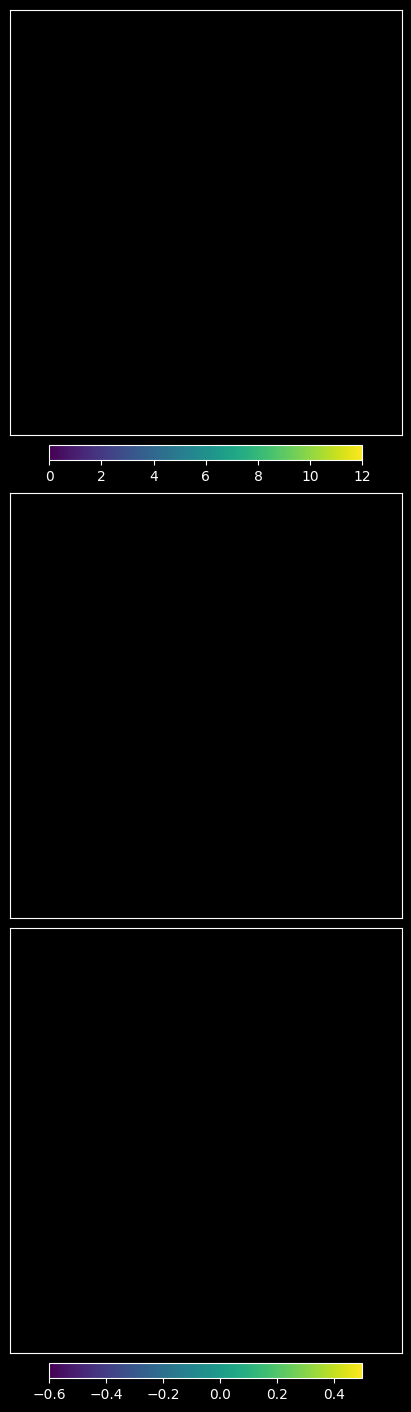

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.animation import writers
from matplotlib.colors import Normalize
from multiprocessing.shared_memory import SharedMemory

pressure_vmin = -0.6
pressure_vmax = 0.5
mag_vmin = 0
mag_vmax = 12


# Set up the figure and axis
fig, (mag_ax, particle_ax, pressure_ax) = plt.subplots(nrows=3, ncols=1, figsize=(4, 14), sharex=True, subplot_kw={'xticks': [], 'yticks': []}, layout='constrained')
#slider = Slider('Frame', 0, V.shape[0] - 1, valinit=0, valstep=1)
#plt.subplots_adjust(bottom=0.1, left=0.1)  # Adjust the bottom and right margins
plt.style.use('dark_background')
# Define the initial frame
current_frame = 0
fig.colorbar(cm.ScalarMappable(norm=Normalize(vmin=mag_vmin, vmax=mag_vmax), cmap='viridis'), ax=mag_ax, shrink=0.8, orientation='horizontal', pad=0.02)
fig.colorbar(cm.ScalarMappable(norm=Normalize(vmin=pressure_vmin, vmax=pressure_vmax), cmap='viridis'), ax=pressure_ax, shrink=0.8, orientation='horizontal', pad=0.02)
# Function to update the plot
def update_plot(current_frame):
    #current_frame = int(slider.val) if val is None else val # Update the current frame
    mag_ax.clear()
    mag_ax.set_title("Speed (m/s)")
    V_frame = V[current_frame]
    V_x, V_y = V_frame[:, :, 0], V_frame[:, :, 1]
    norm = np.sqrt(V_x**2 + V_y**2)  # Calculate the magnitude of the vectors
    # Plot the vector field magnitude
    mag_ax.imshow(norm, cmap='viridis', extent=[x_range[0], x_range[1], x_range[0], x_range[1]], vmin=mag_vmin, vmax=mag_vmax)
    mag_ax.set_xlim(x_range[0], x_range[1])
    mag_ax.set_ylim(x_range[0], x_range[1])
    mag_ax.set_xticks([])
    mag_ax.set_yticks([])
    
    particle_ax.clear()
    plt.style.use('dark_background')
    particle_ax.set_title("Particle Trace")
    particle_ax.set_xlim(x_range[0], x_range[1])
    particle_ax.set_ylim(x_range[0], x_range[1])
    particle_ax.scatter(particle_positions[current_frame, :, 0], particle_positions[current_frame, :, 1], s=0.002, color='hotpink')
    particle_ax.set_xticks([])
    particle_ax.set_yticks([])

    pressure_ax.clear()
    pressure_ax.set_title("Pressure (Pa)")
    pressure_ax.imshow(P[current_frame], cmap='viridis', extent=[x_range[0], x_range[1], x_range[0], x_range[1]], vmin=pressure_vmin, vmax=pressure_vmax)
    pressure_ax.set_xlim(x_range[0], x_range[1])
    pressure_ax.set_ylim(x_range[0], x_range[1])
    pressure_ax.set_xticks([])
    pressure_ax.set_yticks([])
    #fig.canvas.draw_idle()  # Redraw the canvas
    #fig.canvas.flush_events()
    fig.canvas.draw()

# Save the animation as a GIF
# Writer = writers['ffmpeg']
# writer = Writer(fps=60, metadata=dict(artist='Alex M'))
# ani = FuncAnimation(fig, update_plot, frames=range(V.shape[0]-2))
# ani.save('wings1.mp4', writer=writer)


In [37]:
import subprocess
from multiprocessing import Process
import os
def render_section(start_frame, end_frame):
    print(start_frame, end_frame)
    canvas_width, canvas_height = fig.canvas.get_width_height()
    ffmpeg_cmd = [
        'ffmpeg',
        '-f', 'rawvideo',
        '-s', '%dx%d' % (canvas_width, canvas_height),
        '-pix_fmt', 'argb',
        '-r', '10',
        '-i', 'pipe:0',
        f'ffmpeg_temp/{start_frame}_{end_frame}.mp4'
    ]
    # Run FFmpeg with input data piped to stdin
    sub_process = subprocess.Popen(ffmpeg_cmd, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    for frame in range(start_frame,end_frame): #tqdm(range(10), total=10):
        update_plot(frame)
        frame_data = fig.canvas.tostring_argb()
        # try to force feed the frame bytes through the stdin. If it doesn't work, print the error
        try:
            sub_process.stdin.write(frame_data)
        except Exception as e:
            print(f"Error writing frame {frame}: {e}")
            stderr_data = sub_process.stderr.read()
            if stderr_data:
                print(f"FFmpeg stderr: {stderr_data.decode('utf-8')}")
            break

    stdout_data, stderr_data = sub_process.communicate()
    if sub_process.returncode != 0:
        print(f"FFmpeg error: {stderr_data.decode('utf-8')}")
    else:
        print("FFmpeg completed successfully.")


def render(name):
    cores = os.cpu_count()
    frames = particle_positions.shape[0]
    frames_per_process = (frames // cores) + 1
    processes = []
    try:
        os.mkdir('ffmpeg_temp')
    except:
        pass
    for start_frame in range(0, int(cores*frames_per_process), frames_per_process):
        end_frame = min(start_frame + frames_per_process, frames)
        p = Process(target=render_section, args=(start_frame, end_frame))
        processes.append(p)
        p.start()

    for p in processes:
        p.join()
        print(p.exitcode)


    file_list = f'file_list.txt'
    with open(file_list, 'w') as f:
        for start_frame in range(0, int(cores*frames_per_process), frames_per_process):
            f.write(f"file 'temp/{start_frame}_{end_frame}.mp4'\n")
    
    # Construct the FFmpeg command
    ffmpeg_cmd = [
        'ffmpeg',
        '-f', 'concat',
        '-safe', '0',
        '-i', file_list,
        '-c', 'copy',
        f'{name}.mp4'
    ]

    # Run the FFmpeg command
    subprocess.run(ffmpeg_cmd, check=True)
    os.remove(file_list)
    for start_frame in range(0, int(cores*frames_per_process), frames_per_process):
        os.remove(f"'ffmpeg_temp/{start_frame}_{end_frame}.mp4")

    os.rmdir('ffmpeg_temp')


if __name__ == '__main__':
    # do our parallelized rendering:
    render('wing')

1
1
1
1
1
1
1
1


CalledProcessError: Command '['ffmpeg', '-f', 'concat', '-safe', '0', '-i', 'file_list.txt', '-c', 'copy', 'wing.mp4']' returned non-zero exit status 4294967294.

In [ ]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.animation as animation
import subprocess

def testSubprocess(x, y):

    #set up the figure
   # fig = plt.figure(figsize=(15, 9))
    canvas_width, canvas_height = fig.canvas.get_width_height()

    # First frame
   # ax0 = plt.plot(x,y)
    #pointplot, = plt.plot(x[0], y[0], 'or')

    def update(frame):
        # your matplotlib code goes here
        pointplot.set_data(x[frame],y[frame])

    # Open an ffmpeg process
    outf = 'testSubprocess.mp4'
    cmdstring = ('ffmpeg', 
                 '-y', '-r', '1', # overwrite, 1fps
                 '-s', '%dx%d' % (canvas_width, canvas_height), # size of image string
                 '-pix_fmt', 'argb', # format
                 '-f', 'rawvideo',  '-i', '-', # tell ffmpeg to expect raw video from the pipe
                 '-vcodec', 'mpeg4', outf) # output encoding
    p = subprocess.Popen(cmdstring, stdin=subprocess.PIPE)

    # Draw frames and write to the pipe
    for frame in range(nframes):
        # draw the frame
        update(frame)
        fig.canvas.draw()

        # extract the image as an ARGB string
        string = fig.canvas.tostring_argb()

        # write to pipe
        p.stdin.write(string)

    # Finish up
    p.communicate()

# Number of frames
nframes = 200

# Generate data
x = np.linspace(0, 100, num=nframes)
y = np.random.random_sample(np.size(x))

testSubprocess(x, y)

In [ ]:
import multiprocessing
import math
import os

# divide into chunks (https://stackoverflow.com/a/312464/3253411)
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

# number of total frames
frames=1000
frame_iter=[i for i in range(frames)]

# distribute the frames over a set of equally sized chunks
chunk_size=math.ceil(V.shape[0]/multiprocessing.cpu_count())
frame_chunks=list(chunks(frames,chunk_size))

# get temporary video files to write to
filenames=["_temp_video_chunk_" + str(i) + ".mp4") for i in range(len(frame_chunks))]

def ani_to_mp4(frame_set, filename):
    """Animate figure fig for a defined frame set and save in filename (based n (https://stackoverflow.com/a/31315362/3253411)"""
    canvas_width, canvas_height = fig.canvas.get_width_height()

    # Open an ffmpeg process
    outf = os.path.join("results", filename)
    cmdstring = ('ffmpeg', 
                    '-y', '-r', '100', # fps
                    '-s', '%dx%d' % (canvas_width, canvas_height), # size of image string
                    '-pix_fmt', 'argb', # formats
                    '-f', 'rawvideo',  '-i', '-', # tell ffmpeg to expect raw video from the pipe
                    '-vcodec', 'mpeg4', outf) # output encoding
    p = subprocess.Popen(cmdstring, stdin=subprocess.PIPE)

    # Draw frames and write to the pipe
    for frame in frame_range:
        # draw the frame
        animate(frame)
        fig.canvas.draw()

        # extract the image as an ARGB string
        string = fig.canvas.tostring_argb()

        # write to pipe
        p.stdin.write(string)

    # Finish up
    p.communicate()

# take the function to write parallelized the animation chunks to the filenames
with multiprocessing.Pool() as pool:
    pool.starmap(ani_to_mp4, zip(frame_sets, filenames))

# write the filename list to a file
with open("filenames.txt", "w") as textfile:
    for filename in filenames:
        textfile.write("file '" + filename + "'\n")

# and use ffmpeg to concat the resulting mp4 files
cmdstring = ('ffmpeg', '-y',
                '-f', 'concat', 
                '-safe', '0', 
                '-i', "filenames.txt",
                '-c', 'copy', 
                'output.mp4') # output encoding
p = subprocess.Popen(cmdstring, stdin=subprocess.PIPE)

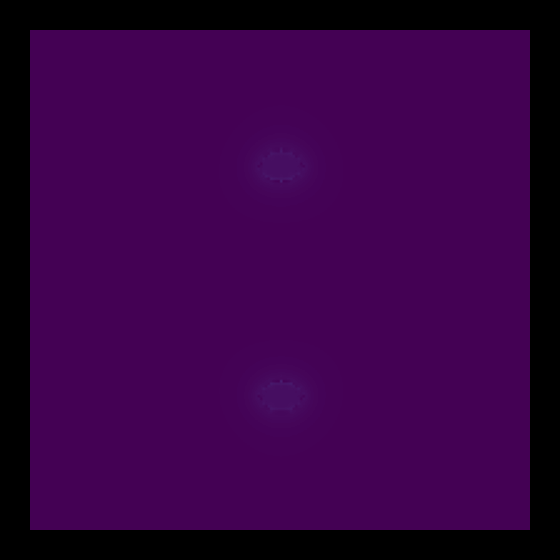

In [ ]:
from matplotlib.animation import writers
import matplotlib
# Set up the figure and axis
#matplotlib.use('Agg')  # Use the Agg backend for rendering
dpi = 300  # Desired resolution (dots per inch)
width, height = 500, 500  # Full HD resolution (adjust as needed)
fig = plt.figure(figsize=(width / dpi, height / dpi), dpi=dpi)
ax = fig.add_axes([0, 0, 1, 1], frameon=False)  # Add axes spanning the entire figure

# Function to plot each frame
def animate(frame):
    frame = 2
    ax.clear()
    #X, Y = np.meshgrid(np.linspace(x_range[0], x_range[1], V.shape[2]), np.linspace(x_range[0], x_range[1], V.shape[1]))
    V_frame = V[frame]
    V_x, V_y = V_frame[:, :, 0], V_frame[:, :, 1]
    norm = np.sqrt(V_x**2 + V_y**2)  # Calculate the distnitude of the vectors
    
    # Plot the vector field distnitude
    im = ax.imshow(norm, cmap='viridis', extent=[x_range[0], x_range[1], x_range[0], x_range[1]], vmax=8)
    ax.set_axis_off()
    #ax.set_xlabel('X')
    #ax.set_ylabel('Y')
    #ax.set_title(f'T: {np.round(frame*dt*iters/samples, 4)}s  KE: {np.round(0.5*np.sum(norm**2)*(dx**2), 3)} joules')

ani = FuncAnimation(fig, animate, frames=(V.shape))

# Save the animation as a GIF
Writer = writers['ffmpeg']
writer = Writer(fps=60, metadata=dict(artist='Me'), bitrate=3000)
ani.save('corners2.mp4', writer=writer)
